In [1]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import collections
import pickle
import gc

In [2]:
df = pd.read_csv('yt_allcountry_trenddays.csv', index_col=None)

In [3]:
df['trend_over_10_days'] = np.where(df["trend_days"]>10, 1, 0)

In [4]:
ten_days = [row for _,row in df.iterrows() if row.trend_over_10_days == 1]
print(f'Amount of videos that trend for more than five days: {len(ten_days)}')

ten_or_less_days = len(df) - len(ten_days)
print(f'Amount of videos that trend for less than or equal to five days: {ten_or_less_days}')

Amount of videos that trend for more than five days: 2341
Amount of videos that trend for less than or equal to five days: 176358


In [5]:
print(f'% of videos that trend for only 1 day = {123974 / len(df)}')
print(f'% of videos that trend for less than or eqaul to 10 day = {ten_or_less_days / len(df)}')

% of videos that trend for only 1 day = 0.6937587787284764
% of videos that trend for less than or eqaul to 10 day = 0.9868997588123045


In [6]:
df_1day = df.copy()
df_1day_nostr = df_1day.drop(['Unnamed: 0','video_id','trending_date','title',
                        'channel_title', 'publish_time','tags',
                        'thumbnail_link','comments_disabled',
                        'ratings_disabled','video_error_or_removed',
                        'description','category','country_code',
                        'trend_days',
                        ],axis=1
                       )

df_1day_nostr

,views,likes,dislikes,comment_count,trend_over_5_days,trend_over_10_days
0,17158579,787425,43420,125882,1,1
1,1014651,127794,1688,13030,0,0
2,3191434,146035,5339,8181,1,0
3,2095828,132239,1989,17518,1,0
4,33523622,1634130,21082,85067,1,1
...,...,...,...,...,...,...
178694,279728,19691,135,579,0,0
178695,1549110,21905,1516,1318,0,0
178696,2183462,79677,2034,3464,0,0
178697,607422,26166,895,3517,0,0


In [7]:
df_1day_nostr = df_1day_nostr.drop(['trend_over_5_days' ] ,axis=1)
df_1day_nostr

,views,likes,dislikes,comment_count,trend_over_10_days
0,17158579,787425,43420,125882,1
1,1014651,127794,1688,13030,0
2,3191434,146035,5339,8181,0
3,2095828,132239,1989,17518,0
4,33523622,1634130,21082,85067,1
...,...,...,...,...,...
178694,279728,19691,135,579,0
178695,1549110,21905,1516,1318,0
178696,2183462,79677,2034,3464,0
178697,607422,26166,895,3517,0


In [8]:
X = df_1day_nostr.drop(['trend_over_10_days'],axis=1)
y = df_1day_nostr['trend_over_10_days']

In [9]:
X

,views,likes,dislikes,comment_count
0,17158579,787425,43420,125882
1,1014651,127794,1688,13030
2,3191434,146035,5339,8181
3,2095828,132239,1989,17518
4,33523622,1634130,21082,85067
...,...,...,...,...
178694,279728,19691,135,579
178695,1549110,21905,1516,1318
178696,2183462,79677,2034,3464
178697,607422,26166,895,3517


In [10]:
y

0         1
1         0
2         0
3         0
4         1
         ..
178694    0
178695    0
178696    0
178697    0
178698    0
Name: trend_over_10_days, Length: 178699, dtype: int32

### PCA on 4 components?

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

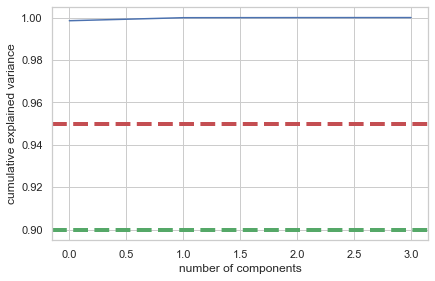

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.998518,0.998518
1,0.999936,0.001419
2,0.999983,0.000047
3,1.000000,0.000017


In [12]:
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
# plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
plt.axhline(linewidth=4, color='r', linestyle = '--', y=0.95, xmin=0, xmax=1)
plt.axhline(linewidth=4, color='g', linestyle = '--', y=0.90, xmin=0, xmax=1)

display(plt.show())

evr = pca.explained_variance_ratio_
cvr = np.cumsum(pca.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

## X use subsets

total n = 178699

1. n = 10000
2. n = 50000
3. n = 100000

## Then Test Train split

In [13]:
X_10k = X[:10000]
X_50k = X[:50000]
X_100k = X[:100000]

y_10k = y[:10000]
y_50k = y[:50000]
y_100k = y[:100000]

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train_10k, X_test_10k, y_train_10k, y_test_10k = train_test_split(X_10k, y_10k, test_size=0.25, random_state=42)
X_train_50k, X_test_50k, y_train_50k, y_test_50k = train_test_split(X_50k, y_50k, test_size=0.25, random_state=42)
X_train_100k, X_test_100k, y_train_100k, y_test_100k = train_test_split(X_100k, y_100k, test_size=0.25, random_state=42)

In [15]:
X_train

,views,likes,dislikes,comment_count
113617,126706,6061,64,4418
65534,14658,122,21,9
126111,9568,141,5,10
8740,32051,3006,40,665
57496,11716,2018,6,130
...,...,...,...,...
119879,7996,38,8,14
103694,78227,1082,45,356
131932,98261,501,60,23
146867,16583,177,14,33


In [16]:
X_test

,views,likes,dislikes,comment_count
117989,2592,125,2,3
101258,30968,1900,32,219
44861,39277,720,72,312
5811,77884,814,119,617
63847,136815,362,201,375
...,...,...,...,...
131037,8259,569,4,86
112353,287445,1475,133,522
75019,78071,1191,42,33
93855,88752,1043,146,118


### Classifier 1: Naive Bayes - Gaussian Naive Bayes

In [17]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, CategoricalNB

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve

In [18]:
%%time
GNB = GaussianNB()
GNB.fit(X_train, y_train)

GNB_predicted = GNB.predict(X_test)
GNB_precision = precision_score(y_test, GNB_predicted)
GNB_recall = recall_score(y_test, GNB_predicted)
GNB_f1 = f1_score(y_test, GNB_predicted)

print(f'Accuracy Score: {GNB.score(X_test, y_test)}')
print(f'Precision Score: {GNB_precision}')
print(f'Recall Score: {GNB_recall}')
print(f'F1 Score: {GNB_f1}')

Accuracy Score: 0.9742361499720201
Precision Score: 0.14
Recall Score: 0.19478260869565217
F1 Score: 0.16290909090909092
Wall time: 37.5 ms


In [19]:
%%time
GNB = GaussianNB()
GNB.fit(X_train_10k, y_train_10k)

GNB_predicted = GNB.predict(X_test_10k)
GNB_precision = precision_score(y_test_10k, GNB_predicted)
GNB_recall = recall_score(y_test_10k, GNB_predicted)
GNB_f1 = f1_score(y_test_10k, GNB_predicted)

print(f'Accuracy Score: {GNB.score(X_test_10k, y_test_10k)}')
print(f'Precision Score: {GNB_precision}')
print(f'Recall Score: {GNB_recall}')
print(f'F1 Score: {GNB_f1}')

Accuracy Score: 0.9424
Precision Score: 0.16470588235294117
Recall Score: 0.16091954022988506
F1 Score: 0.16279069767441862
Wall time: 5 ms


In [20]:
%%time
GNB = GaussianNB()
GNB.fit(X_train_50k, y_train_50k)

GNB_predicted = GNB.predict(X_test_50k)
GNB_precision = precision_score(y_test_50k, GNB_predicted)
GNB_recall = recall_score(y_test_50k, GNB_predicted)
GNB_f1 = f1_score(y_test_50k, GNB_predicted)

print(f'Accuracy Score: {GNB.score(X_test_50k, y_test_50k)}')
print(f'Precision Score: {GNB_precision}')
print(f'Recall Score: {GNB_recall}')
print(f'F1 Score: {GNB_f1}')

Accuracy Score: 0.962
Precision Score: 0.22006472491909385
Recall Score: 0.2251655629139073
F1 Score: 0.2225859247135843
Wall time: 11.5 ms


In [21]:
%%time
GNB = GaussianNB()
GNB.fit(X_train_100k, y_train_100k)

GNB_predicted = GNB.predict(X_test_100k)
GNB_precision = precision_score(y_test_100k, GNB_predicted)
GNB_recall = recall_score(y_test_100k, GNB_predicted)
GNB_f1 = f1_score(y_test_100k, GNB_predicted)

print(f'Accuracy Score: {GNB.score(X_test_100k, y_test_100k)}')
print(f'Precision Score: {GNB_precision}')
print(f'Recall Score: {GNB_recall}')
print(f'F1 Score: {GNB_f1}')

Accuracy Score: 0.96812
Precision Score: 0.22879684418145957
Recall Score: 0.2222222222222222
F1 Score: 0.22546161321671526
Wall time: 20 ms


In [22]:
%%time
from sklearn.model_selection import cross_val_score

GNB_cvs = cross_val_score(GNB, X, y, 
                          cv=10, 
                          n_jobs=-1,)

print(f"GaussianNB 10-CV score: {GNB_cvs}")
print(f"GaussianNB 10-fold Cross Val Avg: {np.mean(GNB_cvs)}")

GaussianNB 10-CV score: [0.93614997 0.96737549 0.97979855 0.98561835 0.97789591 0.98360381
 0.97811975 0.97974259 0.97157247 0.97296995]
GaussianNB 10-fold Cross Val Avg: 0.9732846836594737
Wall time: 1.23 s


In [23]:
print(len(GNB.predict_proba(X_test)))
GNB_probs = GNB.predict_proba(X_test)
GNB_probs
# print(min(GNB_probs[0])

44675


array([[9.99988621e-01, 1.13793753e-05],
       [9.99988991e-01, 1.10085478e-05],
       [9.99989003e-01, 1.09973816e-05],
       ...,
       [9.99989123e-01, 1.08773484e-05],
       [9.99989225e-01, 1.07747570e-05],
       [9.99988675e-01, 1.13246333e-05]])

In [24]:
GNB_probs[:,0]

array([0.99998862, 0.99998899, 0.999989  , ..., 0.99998912, 0.99998923,
       0.99998868])

In [25]:
GNB_probs[:,1]

array([1.13793753e-05, 1.10085478e-05, 1.09973816e-05, ...,
       1.08773484e-05, 1.07747570e-05, 1.13246333e-05])

In [26]:
print(f"min of left col = {min(GNB_probs[:,0])}, max of right col = {max(GNB_probs[:,1])}")
print(f"max of left col = {max(GNB_probs[:,0])}, min of right col = {min(GNB_probs[:,1])}")

min of left col = 0.0, max of right col = 1.0
max of left col = 0.9999896409571556, min of right col = 1.0359042847301652e-05


In [27]:
len(GNB_probs[:,0])

44675

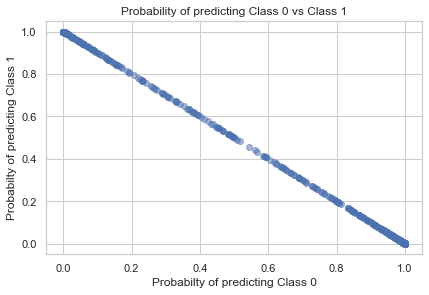

In [28]:
fig, ax = plt.subplots()
plt.scatter(GNB_probs[:,0], GNB_probs[:,1], alpha=0.5)

plt.title('Probability of predicting Class 0 vs Class 1')
ax.set_xlabel('Probabilty of predicting Class 0')
ax.set_ylabel('Probabilty of predicting Class 1')

plt.show()

In [29]:
for i, val in enumerate(GNB_probs[:,0]):
    if i < 10:
        print(i, val)

0 0.9999886206247206
1 0.9999889914522194
2 0.9999890026183538
3 0.9999892378668378
4 0.9999893652396326
5 0.9999889227858435
6 0.9999892926389553
7 0.9999890243931656
8 0.9999881895628957
9 0.9999893466700375


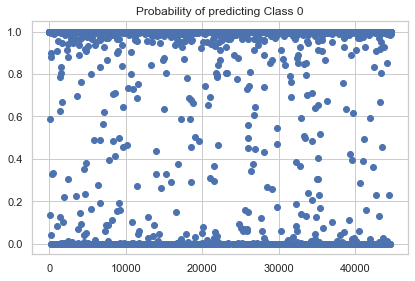

In [30]:
xrange = [i for i in range(len(GNB_probs[:,0]))]
plt.scatter(xrange, GNB_probs[:,0])
plt.title('Probability of predicting Class 0')

plt.show()

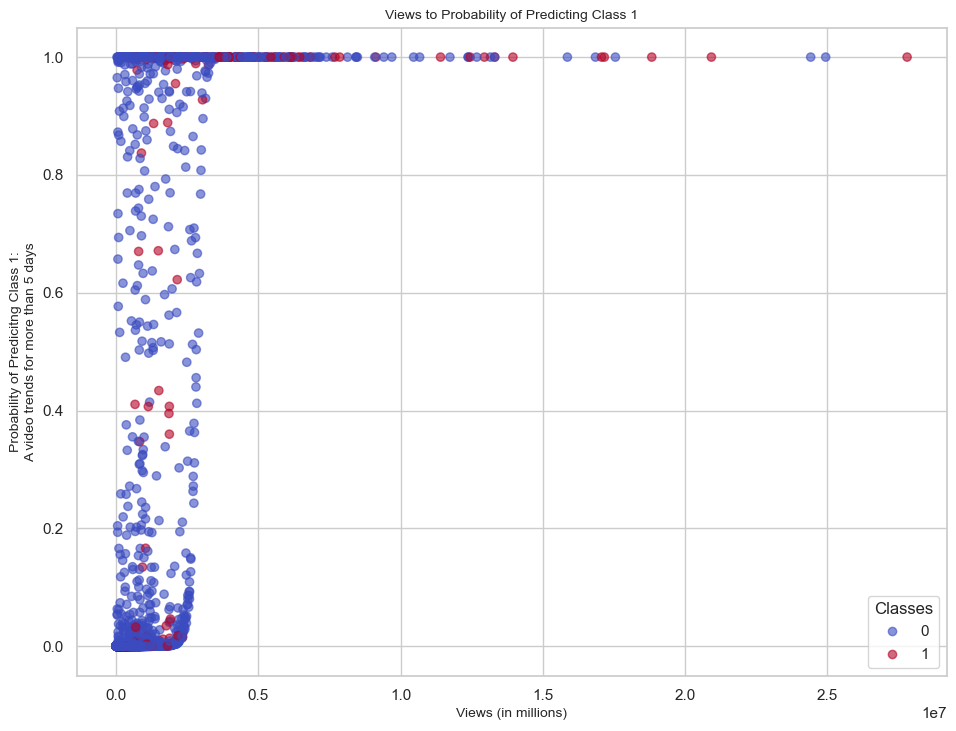

In [31]:
plt.figure(figsize=(10, 8), dpi=100)

scatter = plt.scatter(X_test['views'], GNB_probs[:,1], 
                        c=y_test, 
                        cmap='coolwarm',
                        alpha=0.6)
plt.title('Views to Probability of Predicting Class 1', fontsize='small')
plt.xlabel('Views (in millions)', fontsize='small')
plt.ylabel('Probability of Predicitng Class 1:\nA video trends for more than 5 days', fontsize='small')
plt.rcParams.update({'font.size': 22})


plt.legend(*scatter.legend_elements(), loc='lower right', title='Classes')
# ax.legend()

plt.show()

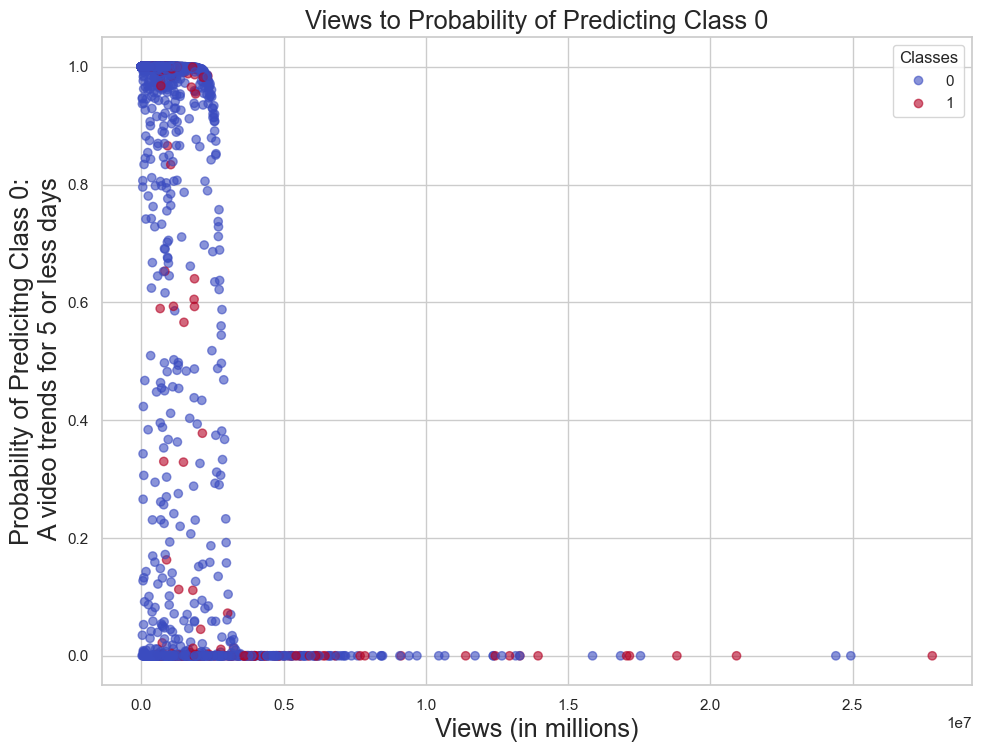

In [32]:
plt.figure(figsize=(10, 8), dpi=100)

scatter = plt.scatter(X_test['views'], GNB_probs[:,0], 
                        c=y_test, 
                        cmap='coolwarm',
                        alpha=0.6)
plt.title('Views to Probability of Predicting Class 0', fontsize='small')
plt.xlabel('Views (in millions)', fontsize='small')
plt.ylabel('Probability of Predicitng Class 0:\n A video trends for 5 or less days', fontsize='small')
plt.rcParams.update({'font.size': 22})


plt.legend(*scatter.legend_elements(), loc='upper right', title='Classes')
# ax.legend()

plt.show()

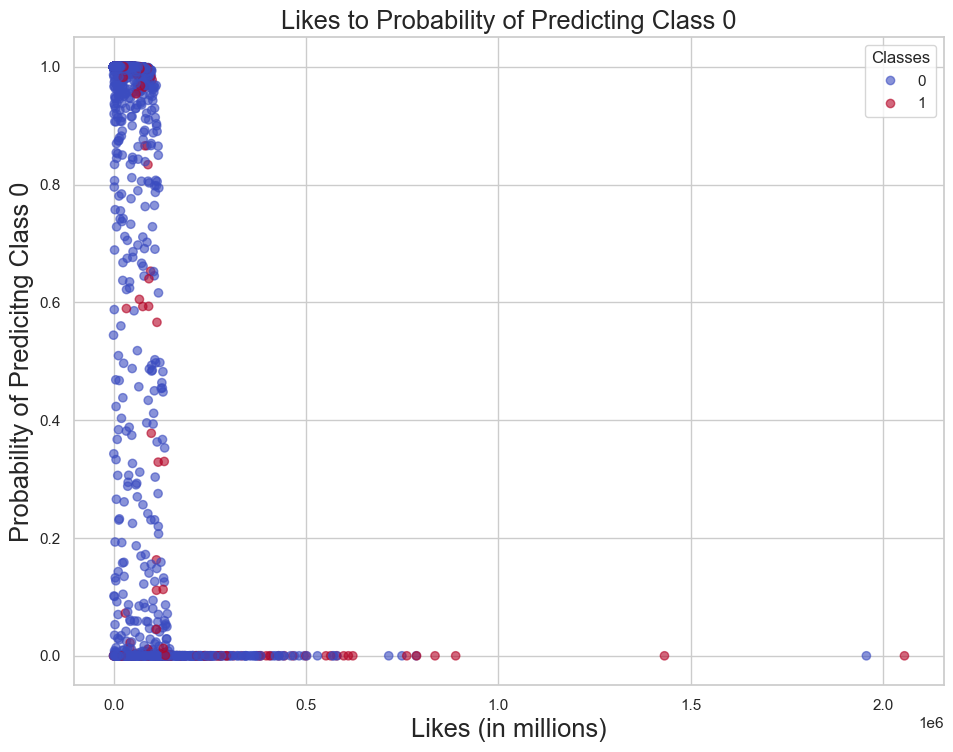

In [33]:
xrange = [i for i in range(len(GNB_probs[:,0]))]

plt.figure(figsize=(10, 8), dpi=100)

scatter = plt.scatter(X_test['likes'], GNB_probs[:,0], 
                        c=y_test, 
                        cmap='coolwarm',
                        alpha=0.6)
plt.title('Likes to Probability of Predicting Class 0', fontsize='small')
plt.xlabel('Likes (in millions)', fontsize='small')
plt.ylabel('Probability of Predicitng Class 0', fontsize='small')
plt.rcParams.update({'font.size': 22})


plt.legend(*scatter.legend_elements(), loc='upper right', title='Classes')
# ax.legend()

plt.show()

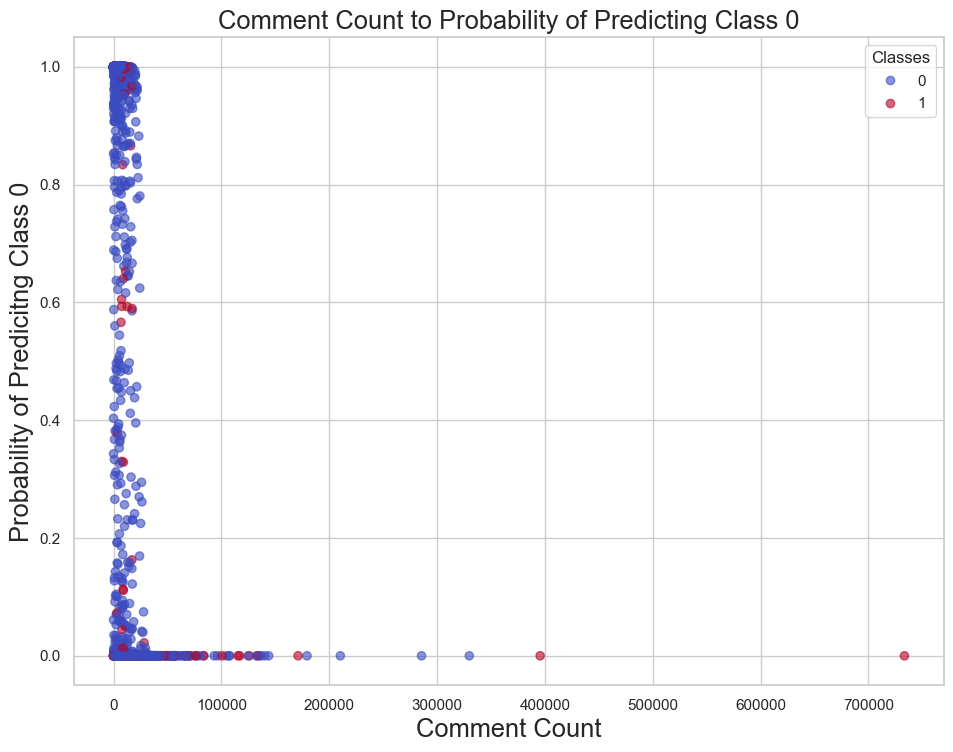

In [34]:
xrange = [i for i in range(len(GNB_probs[:,0]))]

plt.figure(figsize=(10, 8), dpi=100)

scatter = plt.scatter(X_test['comment_count'], GNB_probs[:,0], 
                        c=y_test, 
                        cmap='coolwarm',
                        alpha=0.6)
plt.title('Comment Count to Probability of Predicting Class 0', fontsize='small')
plt.xlabel('Comment Count', fontsize='small')
plt.ylabel('Probability of Predicitng Class 0', fontsize='small')
plt.rcParams.update({'font.size': 22})


plt.legend(*scatter.legend_elements(), loc='upper right', title='Classes')
# ax.legend()

plt.show()

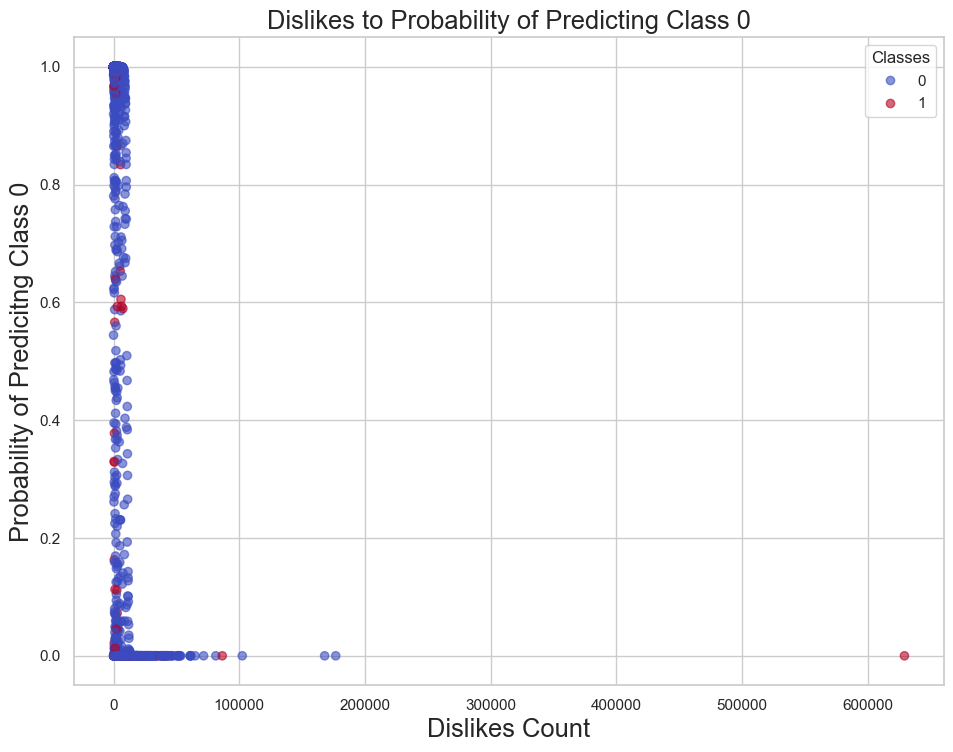

In [35]:
xrange = [i for i in range(len(GNB_probs[:,0]))]

plt.figure(figsize=(10, 8), dpi=100)

scatter = plt.scatter(X_test['dislikes'], GNB_probs[:,0], 
                        c=y_test, 
                        cmap='coolwarm',
                        alpha=0.6)
plt.title('Dislikes to Probability of Predicting Class 0', fontsize='small')
plt.xlabel('Dislikes Count', fontsize='small')
plt.ylabel('Probability of Predicitng Class 0', fontsize='small')
plt.rcParams.update({'font.size': 22})


plt.legend(*scatter.legend_elements(), loc='upper right', title='Classes')
# ax.legend()

plt.show()

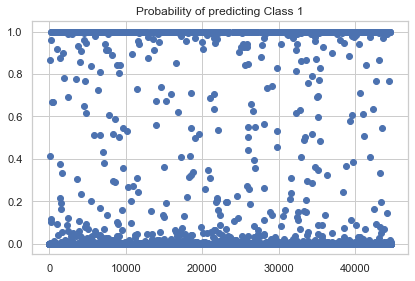

In [36]:
# xrange = [i for i in range(len(GNB_probs[:,0]))]
plt.scatter(xrange, GNB_probs[:,1])
plt.title('Probability of predicting Class 1')

plt.show()

## Histogram to show quantity of predictions to probability

In [37]:
from numpy import arange
bins = [i for i in arange(0.0, 1.0, 0.1)]
bins 

[0.0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9]

In [38]:
import numpy as np

In [39]:
bins = np.linspace(0.0,1.0, num=11)
bins

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

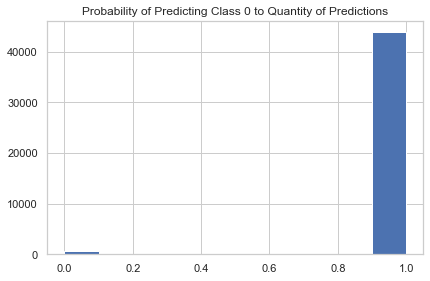

In [40]:
plt.hist(GNB_probs[:,0], bins)
plt.title('Probability of Predicting Class 0 to Quantity of Predictions')

plt.show()

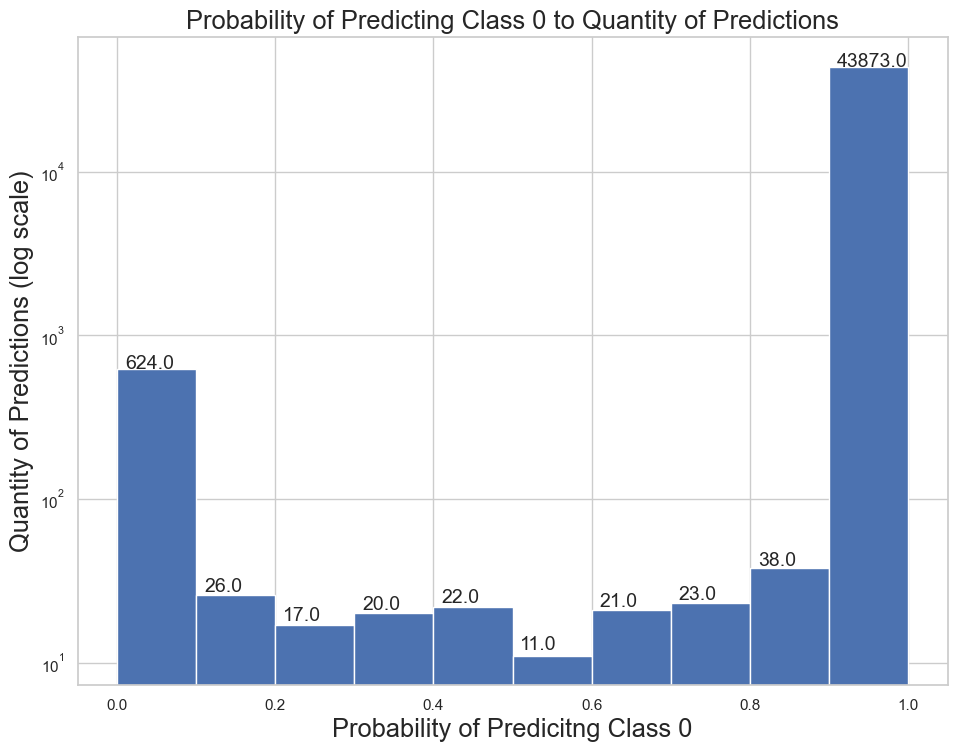

In [41]:
bins2 = 10

plt.figure(figsize=(10, 8), dpi=100)

arr = plt.hist(GNB_probs[:,0], bins2,
#                c=,
              )

# plt.ylim(0,1000)
plt.yscale('log')
plt.title('Probability of Predicting Class 0 to Quantity of Predictions',fontsize='small')
plt.xlabel('Probability of Predicitng Class 0', fontsize='small')
plt.ylabel('Quantity of Predictions (log scale)', fontsize='small')
plt.rcParams.update({'font.size': 22})

for i in range(bins2):
    plt.text(arr[1][i]+0.01,
             arr[0][i]+1,
             str(arr[0][i]), 
             fontsize=14, 
            )
    plt.text(arr[1][i],
             arr[0][i]/1.5,
             str(), 
             fontsize=14, 
            )


plt.show()

In [42]:
arr

(array([6.2400e+02, 2.6000e+01, 1.7000e+01, 2.0000e+01, 2.2000e+01,
        1.1000e+01, 2.1000e+01, 2.3000e+01, 3.8000e+01, 4.3873e+04]),
 array([0.        , 0.09999896, 0.19999793, 0.29999689, 0.39999586,
        0.49999482, 0.59999378, 0.69999275, 0.79999171, 0.89999068,
        0.99998964]),
 <BarContainer object of 10 artists>)

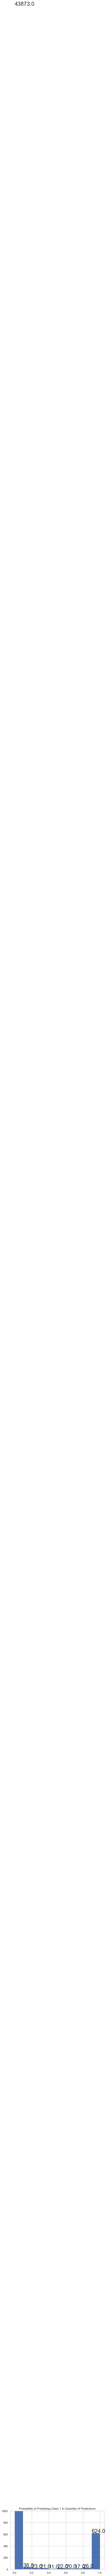

In [43]:
bins2 = 10
arr = plt.hist(GNB_probs[:,1], bins2)
plt.title('Probability of Predicting Class 1 to Quantity of Predictions')
plt.ylim(0,1000)
for i in range(bins2):
    plt.text(arr[1][i],arr[0][i],str(arr[0][i]))
plt.show()

## Calibration Curves

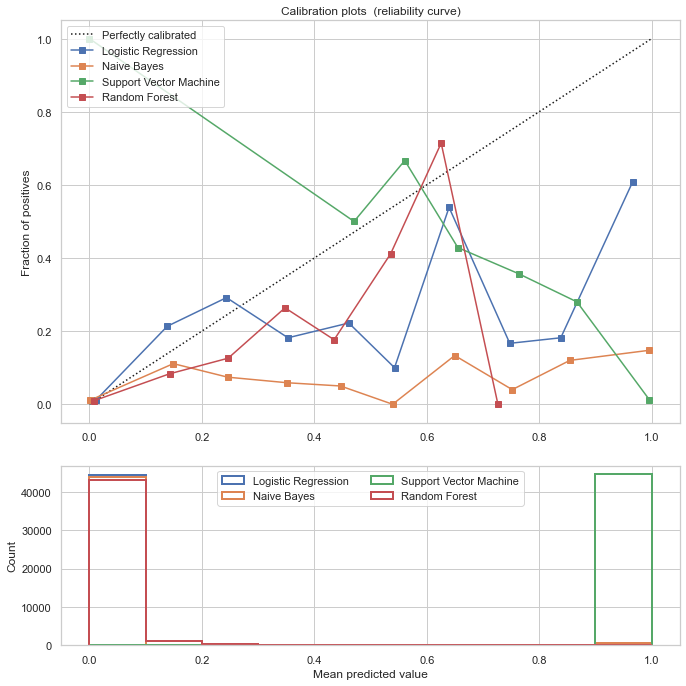

Wall time: 22.9 s


In [44]:
%%time
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import calibration_curve

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

lr = LogisticRegression()
gnb = GaussianNB()
svc = SVC()
rfc = RandomForestClassifier()

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic Regression'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Machine'),
                  (rfc, 'Random Forest')]:
    
#     Already trained
    clf.fit(X_train, y_train)

    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="upper left")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

In [45]:
count = 0
for val in GNB_probs[:,1]:
    if val >= 0.9:
        count += 1
        print(val)

print(f"# of val above 0.9 = {count}")
print(f"% of val above 0.9 = {count/len(GNB_probs[:,1])}")

1.0
0.9583946668551612
1.0
1.0
0.9999999999813198
1.0
1.0
0.9999999143992363
1.0
0.9999999841227237
0.9999970695272915
0.9179486830743477
1.0
0.9992251957747015
0.9999999999987566
1.0
1.0
0.999999865537797
0.9999000895349447
0.9999999998324753
0.999931219055526
0.9970964741055898
0.9999755524158117
1.0
0.9999936924326935
1.0
0.9999999999995239
0.9999999841442816
1.0
0.9979039378390848
0.9984317630229639
1.0
0.9999999999999858
0.999995891401837
0.9999619095696578
0.9880824206747172
0.9999210793102836
1.0
0.9999999999999858
0.9999999999997939
0.9999918221519344
0.9899269670506888
0.9999980774591399
1.0
1.0
1.0
0.9997857489868228
0.9999999998648974
1.0
0.9999999998208509
1.0
0.9999960998419325
0.9999986549434845
1.0
1.0
1.0
0.9982769941643117
0.9998689879116711
0.9999999920777256
0.9299942569123014
1.0
1.0
0.9999999999999858
0.9997200149840493
1.0
0.9999999312899229
0.9999999399195492
1.0
0.9082661820237063
1.0
1.0
1.0
0.9999686153038468
0.9999999967846733
0.9930010488864635
0.99993573245

In [46]:
# fig, ax = plt.subplots()

# x_val=len(GNB_probs)

# ax.bar(x_val, GNB_probs[:,0])


# ax.set_ylabel('Probability')
# ax.set_title('Probability of x_i being in class 0')
# plt.show()

In [47]:
count = 0
for val in GNB_probs[:,0]:
    if 0.8 > val > 0.2:
        count += 1
        print(val)

print(f"# of val around 0.5 = {count}")

0.5856990034067777
0.32990652942072957
0.3330953196411608
0.7839590042218426
0.6242291036721186
0.6663457773988325
0.21979356049501578
0.30620681985663184
0.22474099266356543
0.6972791425846033
0.7644255284859893
0.3529053725617535
0.2324652286364929
0.3815142730312841
0.7978849499452751
0.4868755685135965
0.2753258952535879
0.4876704216164214
0.5660590121052682
0.6217276570683221
0.3953691184766335
0.7051716274502313
0.4847058999960015
0.7108974835803431
0.4116554903670215
0.49778034593538845
0.6450380391394029
0.4566736931200111
0.46728822630789874
0.7325841572295607
0.797966572409161
0.7283241796600161
0.6888497083174009
0.2698829698724512
0.7552840894758911
0.4380343344819095
0.32872606965206663
0.261270347685989
0.6371581808745983
0.3265394347010451
0.2928185459323704
0.37780557201592513
0.589495621348744
0.7804945487242959
0.6859991261867894
0.5876737790520663
0.2902507886524936
0.6763345782872265
0.4539101449178324
0.6614139286902945
0.5025604316593226
0.4822872459278347
0.74139

In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve

In [49]:
 GNB.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [50]:
GNB_predicted = GNB.predict(X_test)
GNB_precision = precision_score(y_test, GNB_predicted)
GNB_recall = recall_score(y_test, GNB_predicted)
GNB_f1 = f1_score(y_test, GNB_predicted)

print(f'Precision Score: {GNB_precision}')
print(f'Recall Score: {GNB_recall}')
print(f'F1 Score: {GNB_f1}')

Precision Score: 0.14527503526093088
Recall Score: 0.1791304347826087
F1 Score: 0.16043613707165108


### Classifier 1b: Bernoulli Naive Bayes

In [ ]:
%%time
BNB = BernoulliNB()
BNB.fit(X_train, y_train)

In [ ]:
%%time
BNB.score(X_test, y_test)

In [ ]:
%%time
from sklearn.model_selection import cross_val_score

BNB_cvs = cross_val_score(BNB, X, y, 
                          cv=10, 
                          n_jobs=-1,)

print(f"GaussianNB 10-CV score: {BNB_cvs}")
print(f"GaussianNB 10-fold Cross Val Avg: {np.mean(BNB_cvs)}")

In [ ]:
BNB_predicted = BNB.predict(X_test)
BNB_precision = precision_score(y_test, BNB_predicted)
BNB_recall = recall_score(y_test, BNB_predicted)
BNB_f1 = f1_score(y_test, BNB_predicted)

print(f'Predicted Array: {BNB_predicted}')
print(f'Precision Score: {BNB_precision}')
print(f'Recall Score: {BNB_recall}')
print(f'F1 Score: {BNB_f1}')

### Classifier 2: Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# %%time
# from sklearn.model_selection import cross_val_score

# clf_log_cvs = cross_val_score(clf_log, X, y, 
#                               cv=10, 
#                               n_jobs=-1,)

# print(f"GaussianNB 10-CV score: {clf_log_cvs}")
# print(f"GaussianNB 10-fold Cross Val Avg: {np.mean(clf_log_cvs)}")

In [51]:
%%time
clf_log = LogisticRegression(random_state=42,
                            verbose=2,
                            n_jobs=-1,)
clf_log.fit(X_train,y_train)

print(f'Accuracy Score:  {clf_log.score(X_test,y_test)}')

clf_log_predicted = clf_log.predict(X_test)
clf_log_precision = precision_score(y_test, clf_log_predicted)
clf_log_recall = recall_score(y_test, clf_log_predicted)
clf_log_f1 = f1_score(y_test, clf_log_predicted)

print(f'Predicted Array: {clf_log_predicted}')
print(f'Precision Score: {clf_log_precision}')
print(f'Recall Score: {clf_log_recall}')
print(f'F1 Score: {clf_log_f1}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


Accuracy Score:  0.9868382764409626
Predicted Array: [0 0 0 ... 0 0 0]
Precision Score: 0.3968253968253968
Recall Score: 0.043478260869565216
F1 Score: 0.07836990595611285
Wall time: 1.36 s


In [52]:
%%time
clf_log = LogisticRegression(random_state=42,
                            verbose=2,
                            n_jobs=-1,)
clf_log.fit(X_train_10k,y_train_10k)

clf_log_predicted = GNB.predict(X_test_10k)
clf_log_precision = precision_score(y_test_10k, clf_log_predicted)
clf_log_recall = recall_score(y_test_10k, clf_log_predicted)
clf_log_f1 = f1_score(y_test_10k, clf_log_predicted)

print(f'Accuracy Score:  {clf_log.score(X_test_10k, y_test_10k)}')
print(f'Precision Score: {clf_log_precision}')
print(f'Recall Score:    {clf_log_recall}')
print(f'F1 Score:        {clf_log_f1}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Accuracy Score:  0.9552
Precision Score: 0.15671641791044777
Recall Score:    0.2413793103448276
F1 Score:        0.19004524886877827
Wall time: 322 ms


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


In [53]:
%%time
clf_log = LogisticRegression(random_state=42,
                            verbose=2,
                            n_jobs=-1,)
clf_log.fit(X_train_50k,y_train_50k)

clf_log_predicted = GNB.predict(X_test_50k)
clf_log_precision = precision_score(y_test_50k, clf_log_predicted)
clf_log_recall = recall_score(y_test_50k, clf_log_predicted)
clf_log_f1 = f1_score(y_test_50k, clf_log_predicted)

print(f'Accuracy Score:  {clf_log.score(X_test_50k, y_test_50k)}')
print(f'Precision Score: {clf_log_precision}')
print(f'Recall Score:    {clf_log_recall}')
print(f'F1 Score:        {clf_log_f1}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Accuracy Score:  0.96528
Precision Score: 0.20610687022900764
Recall Score:    0.2682119205298013
F1 Score:        0.2330935251798561
Wall time: 730 ms


In [54]:
%%time
clf_log = LogisticRegression(random_state=42,
                            verbose=2,
                            n_jobs=-1,)
clf_log.fit(X_train_100k,y_train_100k)

clf_log_predicted = GNB.predict(X_test_100k)
clf_log_precision = precision_score(y_test_100k, clf_log_predicted)
clf_log_recall = recall_score(y_test_100k, clf_log_predicted)
clf_log_f1 = f1_score(y_test_100k, clf_log_predicted)

print(f'Accuracy Score:  {clf_log.score(X_test_100k, y_test_100k)}')
print(f'Precision Score: {clf_log_precision}')
print(f'Recall Score:    {clf_log_recall}')
print(f'F1 Score:        {clf_log_f1}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished


Accuracy Score:  0.97892
Precision Score: 0.22879684418145957
Recall Score:    0.2222222222222222
F1 Score:        0.22546161321671526
Wall time: 1.05 s


In [55]:
log_probs = clf_log.predict_proba(X_test)

In [56]:
print(f"min of left col = {min(log_probs[:,0])}, max of right col = {max(log_probs[:,1])}")
print(f"max of left col = {max(log_probs[:,0])}, min of right col = {min(log_probs[:,1])}")

min of left col = 7.354485498378693e-08, max of right col = 0.999999926455145
max of left col = 0.9916166328971832, min of right col = 0.008383367102816822


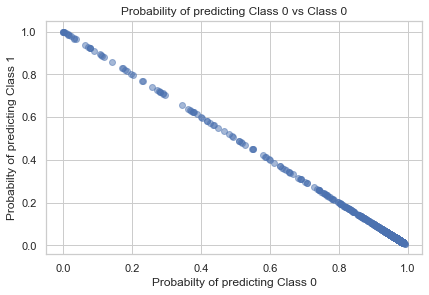

In [57]:
fig, ax = plt.subplots()
plt.scatter(log_probs[:,0], log_probs[:,1], alpha=0.5)

plt.title('Probability of predicting Class 0 vs Class 0')
ax.set_xlabel('Probabilty of predicting Class 0')
ax.set_ylabel('Probabilty of predicting Class 1')

plt.show()

In [58]:
count = 0
for val in log_probs[:,0]:
    if 0.8 > val > 0.2:
        count += 1
        print(val)

print(f"# of val around 0.5 = {count}")

0.37835096702197035
0.7646411383307252
0.42531791882908
0.3763600863295372
0.49163309984741665
0.27140129603658636
0.6681095524521409
0.3996139355265419
0.7860166840242586
0.4171118355662806
0.4655982611767375
0.6596279757373439
0.7721441499610581
0.27760799870434727
0.4494993801161562
0.48105522336816486
0.7661689306356455
0.6290931654012984
0.7031416060803143
0.5966760296882624
0.6891109656100176
0.5280742181062701
0.28151799741416106
0.5868814026470116
0.4885594854584956
0.3756426248338174
0.760751887434575
0.7420227636532568
0.7080591025735103
0.509361094787363
0.7965025808691255
0.6123740361596505
0.5887909377120558
0.5157626672935678
0.780962188244934
0.40409066442089137
0.706822496833133
0.2962208264929469
0.7747689577323637
0.7553279178433656
0.7494376854379902
0.6892243844334067
0.5474042763462431
0.655005507788126
0.5502995798503478
0.36359515519084307
0.6475096345916767
0.7274842095645886
0.2893910090382966
0.34420879739739196
0.627842165885345
0.7422448616033464
0.418333478

In [59]:
count = 0
for val in log_probs[:,1]:
    if val >= 0.9:
        count += 1
        print(val)

print(f"# of val above 0.9 = {count}")
print(f"% of val above 0.9 = {count/len(log_probs[:,1])}")

0.9845991411633905
0.9635623247586377
0.999999926455145
0.9672298707118767
0.9770064728432394
0.9982235959031925
0.9999998023918253
0.9103648925531772
0.9223207323959768
0.998529124382051
0.9928751062378057
0.9694809141097601
0.9221343500135761
0.9858710222383329
0.9271393513127446
0.9871073619778821
0.9377740214364304
0.9999980448630362
0.9209786958867552
# of val above 0.9 = 19
% of val above 0.9 = 0.00042529378847229997


### Classifier 3: Support Vector Machine (SVC)

In [66]:
from sklearn.svm import SVC, LinearSVC

In [ ]:
# %%time
# clf_svm_rbf_cvs = cross_val_score(clf_svm_rbf, X, y, 
#                               cv=10, 
#                               n_jobs=-1,)

# print(f"GaussianNB 10-CV score: {clf_svm_rbf_cvs}")
# print(f"GaussianNB 10-fold Cross Val Avg: {np.mean(clf_svm_rbf_cvs)}")

In [67]:
%%time
clf_svm_rbf = SVC(probability=True,
                  kernel='rbf',
                  verbose=2,
                  random_state=42,)

clf_svm_rbf.fit(X_train,y_train)

clf_svm_rbf_predicted = clf_svm_rbf.predict(X_test)
clf_svm_rbf_precision = precision_score(y_test, clf_svm_rbf_predicted)
clf_svm_rbf_recall = recall_score(y_test, clf_svm_rbf_predicted)
clf_svm_rbf_f1 = f1_score(y_test, clf_svm_rbf_predicted)

print(f'Accuracy Score:  {clf_svm_rbf.score(X_test,y_test)}')
print(f'Precision Score: {clf_svm_rbf_precision}')
print(f'Recall Score: {clf_svm_rbf_recall}')
print(f'F1 Score: {clf_svm_rbf_f1}')

[LibSVM]Accuracy Score:  0.9871740346950196
Precision Score: 0.6666666666666666
Recall Score: 0.006956521739130435
F1 Score: 0.013769363166953529
Wall time: 2min 59s


In [71]:
%%time
clf_svm_rbf = SVC(probability=True,
                  kernel='rbf',
                  verbose=2,
                  random_state=42,)

clf_svm_rbf.fit(X_train_10k, y_train_10k)

clf_svm_rbf_predicted = clf_svm_rbf.predict(X_test_10k)
clf_svm_rbf_precision = precision_score(y_test_10k, clf_svm_rbf_predicted)
clf_svm_rbf_recall = recall_score(y_test_10k, clf_svm_rbf_predicted)
clf_svm_rbf_f1 = f1_score(y_test_10k, clf_svm_rbf_predicted)

print(f'Accuracy Score:  {clf_svm_rbf.score(X_test_10k, y_test_10k)}')
print(f'Precision Score: {clf_svm_rbf_precision}')
print(f'Recall Score: {clf_svm_rbf_recall}')
print(f'F1 Score: {clf_svm_rbf_f1}')

[LibSVM]Accuracy Score:  0.9644
Precision Score: 0.3333333333333333
Recall Score: 0.022988505747126436
F1 Score: 0.04301075268817204
Wall time: 884 ms


In [72]:
%%time
clf_svm_rbf = SVC(probability=True,
                  kernel='rbf',
                  verbose=2,
                  random_state=42,)

clf_svm_rbf.fit(X_train_50k, y_train_50k)

clf_svm_rbf_predicted = clf_svm_rbf.predict(X_test_50k)
clf_svm_rbf_precision = precision_score(y_test_50k, clf_svm_rbf_predicted)
clf_svm_rbf_recall = recall_score(y_test_50k, clf_svm_rbf_predicted)
clf_svm_rbf_f1 = f1_score(y_test_50k, clf_svm_rbf_predicted)

print(f'Accuracy Score:  {clf_svm_rbf.score(X_test_50k, y_test_50k)}')
print(f'Precision Score: {clf_svm_rbf_precision}')
print(f'Recall Score: {clf_svm_rbf_recall}')
print(f'F1 Score: {clf_svm_rbf_f1}')

[LibSVM]Accuracy Score:  0.97584
Precision Score: 0.5
Recall Score: 0.0033112582781456954
F1 Score: 0.006578947368421052
Wall time: 10.8 s


In [73]:
%%time
clf_svm_rbf = SVC(probability=True,
                  kernel='rbf',
                  verbose=2,
                  random_state=42,)

clf_svm_rbf.fit(X_train_100k, y_train_100k)

clf_svm_rbf_predicted = clf_svm_rbf.predict(X_test_100k)
clf_svm_rbf_precision = precision_score(y_test_100k, clf_svm_rbf_predicted)
clf_svm_rbf_recall = recall_score(y_test_100k, clf_svm_rbf_predicted)
clf_svm_rbf_f1 = f1_score(y_test_100k, clf_svm_rbf_predicted)

print(f'Accuracy Score:  {clf_svm_rbf.score(X_test_100k, y_test_100k)}')
print(f'Precision Score: {clf_svm_rbf_precision}')
print(f'Recall Score: {clf_svm_rbf_recall}')
print(f'F1 Score: {clf_svm_rbf_f1}')

[LibSVM]Accuracy Score:  0.97916
Precision Score: 0.6
Recall Score: 0.005747126436781609
F1 Score: 0.011385199240986717
Wall time: 36.8 s


In [ ]:
svm_rbf_probs = GNB.predict_proba(X_test)

In [ ]:
print(f"min of left col = {min(svm_rbf_probs[:,0])}, max of right col = {max(svm_rbf_probs[:,1])}")
print(f"max of left col = {max(svm_rbf_probs[:,0])}, min of right col = {min(svm_rbf_probs[:,1])}")

In [ ]:
fig, ax = plt.subplots()
plt.scatter(svm_rbf_probs[:,0], svm_rbf_probs[:,1], alpha=0.5)

plt.title('Probability of predicting Class 0 vs Class 0')
ax.set_xlabel('Probabilty of predicting Class 0')
ax.set_ylabel('Probabilty of predicting Class 1')

plt.show()

In [ ]:
count = 0
for val in svm_rbf_probs[:,0]:
    if 0.8 > val > 0.2:
        count += 1
        print(val)

print(f"# of val around 0.5 = {count}")
print(f"% of val around 0.5 = {count/len(svm_rbf_probs[:,1])}")

In [ ]:
count = 0
for val in svm_rbf_probs[:,1]:
    if val >= 0.9:
        count += 1
        print(val)

print(f"# of val above 0.9 = {count}")
print(f"% of val above 0.9 = {count/len(svm_rbf_probs[:,1])}")

### LinearSVC

In [ ]:
%%time
from sklearn.svm import LinearSVC

clf_svm_lin = LinearSVC(
#                         probability=True,
                         verbose=2,
                         random_state=42,)

clf_svm_lin.fit(X_train,y_train)

In [ ]:
%%time
clf_svm_lin.score(X_test,y_test)

%%time
from sklearn.model_selection import cross_val_score

clf_svm_lin_cvs = cross_val_score(clf_svm_lin, X, y, 
                              cv=10, 
                              n_jobs=-1,)

print(f"GaussianNB 10-CV score: {clf_svm_lin_cvs}")
print(f"GaussianNB 10-fold Cross Val Avg: {np.mean(clf_svm_lin_cvs)}")

In [ ]:
svm_lin_probs = GNB.predict_proba(X_test)

In [ ]:
print(f"min of left col = {min(svm_lin_probs[:,0])}, max of right col = {max(svm_lin_probs[:,1])}")
print(f"max of left col = {max(svm_lin_probs[:,0])}, min of right col = {min(svm_lin_probs[:,1])}")

In [ ]:
fig, ax = plt.subplots()
plt.scatter(svm_lin_probs[:,0], svm_lin_probs[:,1], alpha=0.5)

plt.title('Probability of predicting Class 0 vs Class 0')
ax.set_xlabel('Probabilty of predicting Class 0')
ax.set_ylabel('Probabilty of predicting Class 1')

plt.show()

In [ ]:
count = 0
for val in svm_lin_probs[:,0]:
    if 0.8 > val > 0.2:
        count += 1
        print(val)

print(f"# of val around 0.5 = {count}")
print(f"% of val around 0.5 = {count/len(svm_lin_probs[:,1])}")

In [ ]:
count = 0
for val in svm_lin_probs[:,1]:
    if val >= 0.9:
        count += 1
        print(val)

print(f"# of val above 0.9 = {count}")
print(f"% of val above 0.9 = {count/len(svm_lin_probs[:,1])}")

### Classifier 4: Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
%%time
clf_rdf.score(X_test,y_test)

In [ ]:
# %%time
# from sklearn.model_selection import cross_val_score

# clf_rdf_cvs = cross_val_score(clf_rdf, X, y, 
#                               cv=10, 
#                               n_jobs=-1,)

# print(f"GaussianNB 10-CV score: {clf_rdf_cvs}")
# print(f"GaussianNB 10-fold Cross Val Avg: {np.mean(clf_rdf_cvs)}")

In [60]:
%%time
clf_rdf = RandomForestClassifier(n_jobs=-1,
                       random_state=42,
#                        verbose=2,
                                )

clf_rdf.fit(X_train,y_train)

clf_rdf_predicted = clf_rdf.predict(X_test)
clf_rdf_precision = precision_score(y_test, clf_rdf_predicted)
clf_rdf_recall = recall_score(y_test, clf_rdf_predicted)
clf_rdf_f1 = f1_score(y_test, clf_rdf_predicted)

print(f'Accuracy Score:  {clf_rdf.score(X_test,y_test)}')
print(f'Precision Score: {clf_rdf_precision}')
print(f'Recall Score: {clf_rdf_recall}')
print(f'F1 Score: {clf_rdf_f1}')

Accuracy Score:  0.9870397313933967
Precision Score: 0.4
Recall Score: 0.01391304347826087
F1 Score: 0.026890756302521007
Wall time: 1.39 s


In [61]:
%%time
clf_rdf = RandomForestClassifier(n_jobs=-1,
                       random_state=42,
#                        verbose=2,
                                )
clf_rdf.fit(X_train_10k,y_train_10k)

clf_rdf_predicted = clf_rdf.predict(X_test_10k)
clf_rdf_precision = precision_score(y_test_10k, clf_rdf_predicted)
clf_rdf_recall = recall_score(y_test_10k, clf_rdf_predicted)
clf_rdf_f1 = f1_score(y_test_10k, clf_rdf_predicted)

print(f'Accuracy Score:  {clf_rdf.score(X_test_10k, y_test_10k)}')
print(f'Precision Score: {clf_rdf_precision}')
print(f'Recall Score: {clf_rdf_recall}')
print(f'F1 Score: {clf_rdf_f1}')

Accuracy Score:  0.9652
Precision Score: 0.5
Recall Score: 0.06896551724137931
F1 Score: 0.1212121212121212
Wall time: 463 ms


In [62]:
%%time
clf_rdf = RandomForestClassifier(n_jobs=-1,
                       random_state=42,
#                        verbose=2,
                                )
clf_rdf.fit(X_train_50k,y_train_50k)

clf_rdf_predicted = clf_rdf.predict(X_test_50k)
clf_rdf_precision = precision_score(y_test_50k, clf_rdf_predicted)
clf_rdf_recall = recall_score(y_test_50k, clf_rdf_predicted)
clf_rdf_f1 = f1_score(y_test_50k, clf_rdf_predicted)

print(f'Accuracy Score:  {clf_rdf.score(X_test_50k, y_test_50k)}')
print(f'Precision Score: {clf_rdf_precision}')
print(f'Recall Score: {clf_rdf_recall}')
print(f'F1 Score: {clf_rdf_f1}')

Accuracy Score:  0.9752
Precision Score: 0.34615384615384615
Recall Score: 0.029801324503311258
F1 Score: 0.054878048780487805
Wall time: 588 ms


In [63]:
%%time
clf_rdf = RandomForestClassifier(n_jobs=-1,
                       random_state=42,
#                        verbose=2,
                                )
clf_rdf.fit(X_train_100k,y_train_100k)

clf_rdf_predicted = clf_rdf.predict(X_test_100k)
clf_rdf_precision = precision_score(y_test_100k, clf_rdf_predicted)
clf_rdf_recall = recall_score(y_test_100k, clf_rdf_predicted)
clf_rdf_f1 = f1_score(y_test_100k, clf_rdf_predicted)

print(f'Accuracy Score:  {clf_rdf.score(X_test_100k, y_test_100k)}')
print(f'Precision Score: {clf_rdf_precision}')
print(f'Recall Score: {clf_rdf_recall}')
print(f'F1 Score: {clf_rdf_f1}')

Accuracy Score:  0.97884
Precision Score: 0.42857142857142855
Recall Score: 0.040229885057471264
F1 Score: 0.07355516637478109
Wall time: 946 ms


In [ ]:
rdf_probs = GNB.predict_proba(X_test)

In [ ]:
print(f"min of left col = {min(rdf_probs[:,0])}, max of right col = {max(rdf_probs[:,1])}")
print(f"max of left col = {max(rdf_probs[:,0])}, min of right col = {min(rdf_probs[:,1])}")

In [ ]:
fig, ax = plt.subplots()
plt.scatter(rdf_probs[:,0], rdf_probs[:,1], alpha=0.5)

plt.title('Probability of predicting Class 0 vs Class 0')
ax.set_xlabel('Probabilty of predicting Class 0')
ax.set_ylabel('Probabilty of predicting Class 1')

plt.show()

In [ ]:
count = 0
for val in rdf_probs[:,0]:
    if 0.8 > val > 0.2:
        count += 1
        print(val)

print(f"# of val around 0.5 = {count}")
print(f"% of val around 0.5 = {count/len(rdf_probs[:,1])}")

In [ ]:
count = 0
for val in rdf_probs[:,1]:
    if val >= 0.9:
        count += 1
        print(val)

print(f"# of val above 0.9 = {count}")
print(f"% of val above 0.9 = {count/len(rdf_probs[:,1])}")

## Reappending the prediction probabilites after Gaussian NB back on X_test, to observe some behavior

1. Add predicts back on to new dataframe with X_test
2. use clf to parse for feature importance

In [ ]:
X_test_probs = X_test.copy()

GNB = GaussianNB()
GNB.fit(X_train, y_train)
GNB_predicted = GNB.predict(X_test)

X_test_probs['prob_0'] = GNB_probs[:,0]
X_test_probs['prob_1'] = GNB_probs[:,1]
X_test_probs['predict_class'] = GNB.predict(X_test)
X_test_probs['label'] = y_test
X_test_probs

In [ ]:
plt.figure(figsize=(10, 8), dpi=100)

scatter = plt.scatter(X_test_probs['views'], GNB_probs[:,0], 
                        c=X_test_probs['predict_class'], 
                        cmap='coolwarm',
                        alpha=0.6)
plt.title('Views to Probability of Predicting Class 0', fontsize='small')
plt.xlabel('Views (in millions)', fontsize='small')
plt.ylabel('Probability of Predicitng Class 0', fontsize='small')
plt.rcParams.update({'font.size': 22})


plt.legend(*scatter.legend_elements(), loc='upper right', title='Predicted Classes')
# ax.legend()

plt.show()

In [ ]:
xrange = [i for i in range(len(GNB_probs[:,0]))]

plt.figure(figsize=(10, 8), dpi=100)

scatter = plt.scatter(X_test['comment_count'], GNB_probs[:,0], 
                        c=X_test_probs['predict_class'], 
                        cmap='coolwarm',
                        alpha=0.6)
plt.title('Comment Count to Probability of Predicting Class 0', fontsize='small')
plt.xlabel('Comment Count', fontsize='small')
plt.ylabel('Probability of Predicitng Class 0', fontsize='small')
plt.rcParams.update({'font.size': 22})


plt.legend(*scatter.legend_elements(), loc='upper right', title='Classes')
# ax.legend()

plt.show()

In [ ]:
GNB.feature_log_prob_

In [ ]:
X_test_probs

In [ ]:
# to first affirm that prob_0 and prob_1 were truly labeled as what they were supposed to be

count = 0
for i, row in X_test_probs.iterrows():
    count += 1
    if count > 5:
        break
    print(f'i:{i}, V:{row.views}, L:{row.likes}, D:{row.dislikes}, C:{row.comment_count}')
    print(f'i:{i}, Prob_0:{row.prob_0}, Prob_1:{row.prob_1}, Label:{row.label}\n')

In [ ]:
count = 0
for i, row in X_caltest_probs.iterrows():
    if 0.65 > row.prob_0 > 0.45:
        count += 1
        print(f'i:{i}, V:{row.views}, L:{row.likes}, D:{row.dislikes}, C:{row.comment_count}')
        print(f'i:{i}, Prob_0:{row.prob_0}, Prob_1:{row.prob_1}, Label:{row.label}\n')
        
print(f'\nCount = {count}')

### Other observations

In [ ]:
len(X_test)

In [ ]:
np.array(X_test[19:20])

In [ ]:
y_test[19:20]

In [ ]:
GNB.predict_proba(X_test[:-1])

In [ ]:
GNB.predict(X_test[5::-1])

In [ ]:
# custom 
print(GNB.predict(np.array([[17158579, 787425, 43420, 125882]])))
print(GNB.predict_proba(np.array([[17158579, 787425, 43420, 125882]])))

In [ ]:
# custom 
arr2 = [4567, 787, 430, 125]
print(GNB.predict(np.array([arr2])))
print(GNB.predict_proba(np.array([arr2])))

### Using only views, comments, and likes to graph 3D

In [ ]:
X3 = X.drop(['dislikes'],axis=1)
X3

In [ ]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, test_size=0.25, random_state=42)

In [ ]:
X3_train

In [ ]:
y3_train

### Gaussian Naive Bayes on views, comments, likes, only

In [ ]:
GNB_3 = GaussianNB()
GNB_3.fit(X3_train, y3_train)

In [ ]:
GNB_3.score(X3_test, y3_test)

In [ ]:
from sklearn.model_selection import cross_val_score

GNB_3_cvs = cross_val_score(GNB_3, X, y, 
                          cv=10, 
                          n_jobs=-1,)

print(GNB_3_cvs)
print(f"GaussianNB 10-fold Cross Val Avg: {np.mean(GNB_3_cvs)}")

### Bernoulli Naive Bayes on 4 stats, then the 3 stats

In [ ]:
from sklearn.naive_bayes import BernoulliNB

BNB = BernoulliNB()
BNB.fit(X_train, y_train)

In [ ]:
BNB.score(X_test, y_test)

In [ ]:
BNB_cvs = cross_val_score(BNB, X, y, 
                          cv=10, 
                          n_jobs=-1,)

print(f"GaussianNB 10-CV score: {BNB_cvs}")
print(f"GaussianNB 10-fold Cross Val Avg: {np.mean(BNB_cvs)}")

In [ ]:
from sklearn.naive_bayes import BernoulliNB

BNB = BernoulliNB()
BNB.fit(X3_train, y_train)

In [ ]:
BNB.score(X3_test, y_test)

In [ ]:
BNB_cvs = cross_val_score(BNB, X, y, 
                          cv=10, 
                          n_jobs=-1,)

print(f"GaussianNB 10-CV score: {BNB_cvs}")
print(f"GaussianNB 10-fold Cross Val Avg: {np.mean(BNB_cvs)}")

### Random Forest Classifier on 4 stats, looking at feature importance

In [ ]:
%%time 
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train,y_train)

In [ ]:
%%time
rf_clf.score(X_test,y_test)

## Taking a look at feature importance from Random Forest

In [ ]:
# quick investigation into the correlation of features to the label
df_nostr.corr()["trend_over_5_days"].sort_values(ascending=False)

In [ ]:
rf_clf.feature_importances_

In [ ]:
plt.barh(X.columns, rf_clf.feature_importances_)

In [ ]:
%%time
import shap

explainer = shap.TreeExplainer(rf_clf)

In [ ]:
%%time
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.summary_plot(shape_values, X_test, plot_type="bar")

In [ ]:
shap.summary_plot(shape_values, X_train)

In [ ]:
# X = np.array([[-1, -1], [-2, -1], [1, 1], [2, 1]])
# y = np.array([1, 1, 2, 2])
# from sklearn.svm import SVC
# clf = SVC(probability=True)
# clf.fit(X, y) 
# print(clf.predict([[-0.8, -1]]))
# print(clf.predict_proba([[-0.8, -1]]))

### Heat Map remade with Spearman's rank correlation 

In [ ]:
import seaborn as sns

sns.heatmap(df_nostr.corr(method='spearman'),annot=True,cmap='coolwarm')

In [ ]:
sns.heatmap(df_nostr.corr(method='pearson'),annot=True,cmap='coolwarm_r')

In [ ]:
df_nostr.corr(method='pearson')['trend_over_5_days']